### About dataset

This dataset is about past loans. The Loan_train.csv data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

**Field**	-- **Description**

- Loan_status --> Whether a loan is paid off on in collection
- Principal	--> Basic principal loan amount at the
- Terms	--> Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule
- Effective_date --> When the loan got originated and took effects
- Due_date	--> Since it’s one-time payoff schedule, each loan has one single due date
- Age	--> Age of applicant
- Education --> Education of applicant
- Gender --> The gender of applicant


In [56]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import warnings
from sklearn.utils import resample
from sklearn.svm import SVC
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
warnings.simplefilter(action='ignore', category=FutureWarning)

In [57]:
df = pd.read_csv('loan_train.csv')
df.tail(100)

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
246,284,284,PAIDOFF,1000,15,9/14/2016,9/28/2016,24,Bechalor,male
247,285,285,PAIDOFF,1000,30,9/14/2016,11/12/2016,34,Bechalor,male
248,286,286,PAIDOFF,1000,30,9/14/2016,10/13/2016,29,college,male
249,288,288,PAIDOFF,1000,30,9/14/2016,10/13/2016,34,Bechalor,male
250,289,289,PAIDOFF,800,15,9/14/2016,9/28/2016,28,High School or Below,male
...,...,...,...,...,...,...,...,...,...,...
341,394,394,COLLECTION,800,15,9/11/2016,9/25/2016,32,High School or Below,male
342,395,395,COLLECTION,1000,30,9/11/2016,10/10/2016,25,High School or Below,male
343,397,397,COLLECTION,800,15,9/12/2016,9/26/2016,39,college,male
344,398,398,COLLECTION,1000,30,9/12/2016,11/10/2016,28,college,male


In [58]:
df.shape

(346, 10)

In [59]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

<AxesSubplot:>

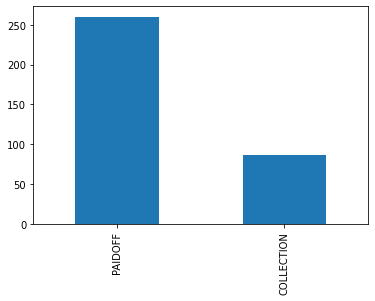

In [60]:
df['loan_status'].value_counts().plot(kind='bar')

260 people have paid off the loan on time while 86 have gone into collectio

In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 346 entries, 0 to 345
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      346 non-null    int64 
 1   Unnamed: 0.1    346 non-null    int64 
 2   loan_status     346 non-null    object
 3   Principal       346 non-null    int64 
 4   terms           346 non-null    int64 
 5   effective_date  346 non-null    object
 6   due_date        346 non-null    object
 7   age             346 non-null    int64 
 8   education       346 non-null    object
 9   Gender          346 non-null    object
dtypes: int64(5), object(5)
memory usage: 27.2+ KB


### Data Cleaning

In [62]:
df.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'loan_status', 'Principal', 'terms',
       'effective_date', 'due_date', 'age', 'education', 'Gender'],
      dtype='object')

In [63]:
#dropping unnecessary columns unnamed 0 and 0.1
df = df.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'],axis=1)

In [64]:
# Date time conversion
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


### Data Exploration

#### Plotting Loan Status for various Principal Amount

Text(0.5, 1.0, 'Loan PAIDOFF/COLLECTION count for various Principal Amount')

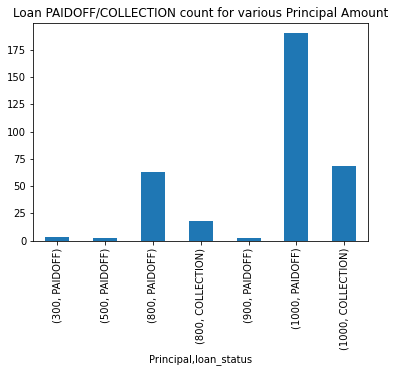

In [65]:
df.groupby(['Principal'])['loan_status'].value_counts().plot(kind='bar')
plt.title('Loan PAIDOFF/COLLECTION count for various Principal Amount')

**We can see that there are more number of collection pending as premium amount increasing**

#### Plotting Loan Status for various Terms

Text(0.5, 1.0, 'Loan PAIDOFF/COLLECTION count for various Terms')

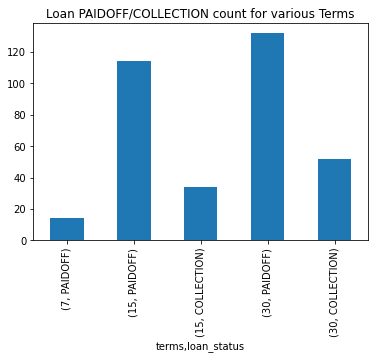

In [66]:
df.groupby(['terms'])['loan_status'].value_counts().plot(kind='bar')
plt.title('Loan PAIDOFF/COLLECTION count for various Terms')

**We can see that there are more number of collection pending as term increasing**

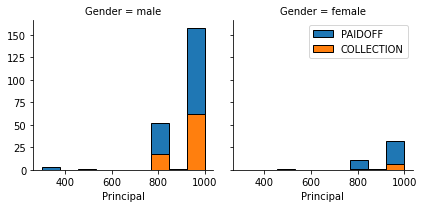

Gender  loan_status
female  PAIDOFF         45
        COLLECTION       7
male    PAIDOFF        215
        COLLECTION      79
Name: loan_status, dtype: int64

In [67]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()
df.groupby(['Gender'])['loan_status'].value_counts()

**We can see that Male has more number of collection pending as compare to female**

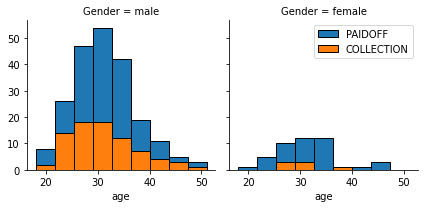

In [68]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

Text(0.5, 1.0, 'Loan PAIDOFF/COLLECTION count for education qualifications')

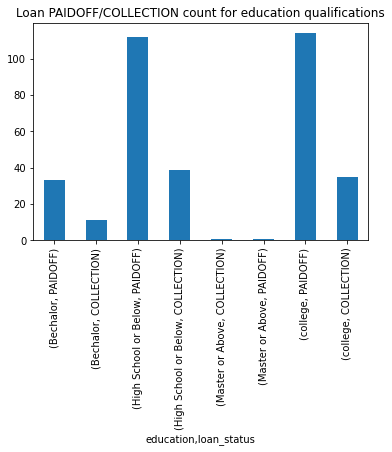

In [69]:
df.groupby(['education'])['loan_status'].value_counts().plot(kind='bar')
plt.title('Loan PAIDOFF/COLLECTION count for education qualifications')

In [70]:
df.shape

(346, 8)

**We can observe that more number of collection pending between approx Age in between 25-35**

From above plots we can conclude that **Age , Gender , Principal, Term , Education** can be used for deciding loan status

### Pre-processing:  Feature extraction

#### Lets look at the day of the week people get the loan 

Text(0.5, 1.0, 'Loan PAIDOFF/COLLECTION count for day of the week people get the loan')

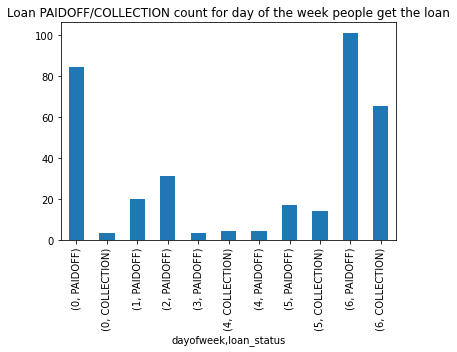

In [71]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
df.groupby(['dayofweek'])['loan_status'].value_counts().plot(kind='bar')
plt.title('Loan PAIDOFF/COLLECTION count for day of the week people get the loan')

We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set greater than 4 as weekend i.e 1 less than 4 as 0

In [72]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)

,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend,Difference_effective_due_date
0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0,29
1,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0,29
2,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0,14
3,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1,29
4,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1,29


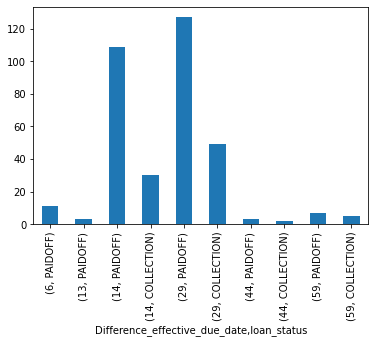

In [73]:
df['Difference_effective_due_date'] = (df['due_date'] - df['effective_date']).dt.days
df['Difference_effective_due_date']
df.groupby(['Difference_effective_due_date'])['loan_status'].value_counts().plot(kind='bar')
df.head()

#### Convert Categorical features to numerical values

In [74]:
df['Gender'].replace(to_replace=['male','female'], value=[1,0],inplace=True)
df['loan_status']=  np.where(df['loan_status']=='PAIDOFF',0,1)  
df['loan_status']
df.head()

,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend,Difference_effective_due_date
0,0,1000,30,2016-09-08,2016-10-07,45,High School or Below,1,3,0,29
1,0,1000,30,2016-09-08,2016-10-07,33,Bechalor,0,3,0,29
2,0,1000,15,2016-09-08,2016-09-22,27,college,1,3,0,14
3,0,1000,30,2016-09-09,2016-10-08,28,college,0,4,1,29
4,0,1000,30,2016-09-09,2016-10-08,29,college,1,4,1,29


#### One Hot Encoding  

#### Use one hot encoding technique to convert categorical varables to binary variables and append them to the feature Data Frame 

In [75]:
Feature = pd.get_dummies(df[['Principal','terms','age','Gender','weekend','education']],columns=['education'],drop_first=True)
Feature.head()


,Principal,terms,age,Gender,weekend,education_High School or Below,education_Master or Above,education_college
0,1000,30,45,1,0,1,0,0
1,1000,30,33,0,0,0,0,0
2,1000,15,27,1,0,0,0,1
3,1000,30,28,0,1,0,0,1
4,1000,30,29,1,1,0,0,1


In [76]:
X =Feature
y= df['loan_status'].values
from sklearn.model_selection import train_test_split
#splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=4)
print(X_train.shape,X_test.shape,y_train.shape, y_test.shape)

(294, 8) (52, 8) (294,) (52,)


### Normalize Data 

Data Standardization give with data **zero mean and unit variance**

In [77]:
sc=StandardScaler()
X_train= sc.fit_transform(X_train)
X_test= sc.transform(X_test)

### Upsample minor class

In [78]:
X_train_u, y_train_u = resample(X_train[y_train == 1],
                                y_train[y_train == 1],
                                replace=True,
                                n_samples=X_train[y_train == 0].shape[0],
                                random_state=1)
X_train_u = np.concatenate((X_train[y_train == 0], X_train_u))
y_train_u = np.concatenate((y_train[y_train == 0], y_train_u))
print('Before Upsampling y_train == 1',X_train[y_train == 1].shape)
print('Before Upsampling y_train == 0',X_train[y_train == 0].shape)
print('After Upsampling y_train == 1',X_train_u[y_train_u == 1].shape)
print('After Upsampling y_train == 0',X_train_u[y_train_u == 0].shape)

Before Upsampling y_train == 1 (76, 8)
Before Upsampling y_train == 0 (218, 8)
After Upsampling y_train == 1 (218, 8)
After Upsampling y_train == 0 (218, 8)


### Model Training

### Logistic Regression

In [79]:
# GRID SEARCH
logreg=LogisticRegression(solver='lbfgs')
grid={"C":np.logspace(-3,3,7)}
logreg_cv=GridSearchCV(logreg,grid,cv=5)
logreg_cv.fit(X_train_u,y_train_u)


print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 0.001}
accuracy : 0.763662486938349


In [80]:
clflr = LogisticRegression(C = 0.001, solver='lbfgs')
clflr.fit(X_train_u, y_train_u)
y_pred = clflr.predict(X_test)

print("Model 4: Log_reg Train set Accuracy: ", metrics.accuracy_score(y_train_u, clflr.predict(X_train_u)))
print("Model 4: Log_reg Validation set Accuracy: ", metrics.accuracy_score(y_test, y_pred))
print("Model 4: Log_reg Jaccard Score:",jaccard_score(y_test, y_pred))
print("Model 4: Log_reg F1 Score", f1_score(y_test, y_pred))
print("Model 4: Log_reg log_loss Score", log_loss(y_test, y_pred))

Model 4: Log_reg Train set Accuracy:  0.7775229357798165
Model 4: Log_reg Validation set Accuracy:  0.5192307692307693
Model 4: Log_reg Jaccard Score: 0.2647058823529412
Model 4: Log_reg F1 Score 0.41860465116279066
Model 4: Log_reg log_loss Score 16.60555000405946


### SVM  Classifiers

In [81]:
# GRID SEARCH
C = [0.001, 0.01, 0.1, 1, 10]
gammas = [0.001, 0.01, 0.1, 1]
param_grid = {'C': C, 'gamma' : gammas}
clfsvm_cv = GridSearchCV(SVC(), param_grid, cv=5)
clfsvm_cv.fit(X_train_u, y_train_u)

print("tuned hpyerparameters :(best parameters) ",clfsvm_cv.best_params_)
print("accuracy :",clfsvm_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 10, 'gamma': 1}
accuracy : 0.8211076280041798


In [82]:
clfsvm = SVC( C = 10,gamma=1)
clfsvm.fit(X_train_u, y_train_u)
y_pred = clfsvm.predict(X_test)

print("Model 3: SVM Train set Accuracy: ", metrics.accuracy_score(y_train_u, clfsvm.predict(X_train_u)))
print("Model 3: SVM Validation set Accuracy: ", metrics.accuracy_score(y_test, y_pred))
print("Model 3: SVM Jaccard Score:",jaccard_score(y_test, y_pred))
print("Model 3: SVM F1 Score", f1_score(y_test, y_pred))

Model 3: SVM Train set Accuracy:  0.8715596330275229
Model 3: SVM Validation set Accuracy:  0.5769230769230769
Model 3: SVM Jaccard Score: 0.2413793103448276
Model 3: SVM F1 Score 0.3888888888888889


#### Taken Function from sklearn

In [83]:
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

#### Learning Curve for SVM & Logistic Regression

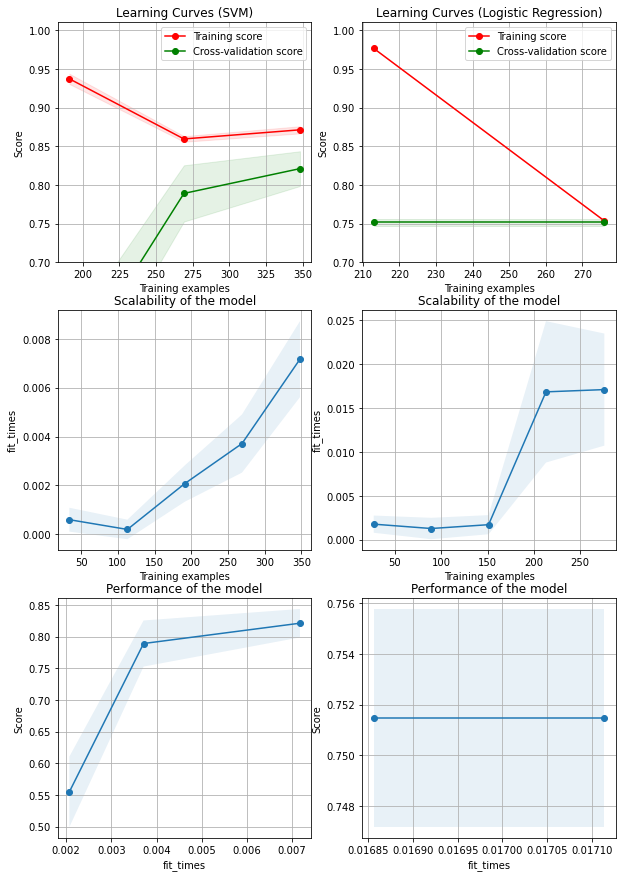

In [84]:
from sklearn.model_selection import learning_curve 
fig, axes = plt.subplots(3, 2, figsize=(10, 15))

title = "Learning Curves (SVM)"
plot_learning_curve(clfsvm, title, X_train_u, y_train_u, axes=axes[:, 0], ylim=(0.7, 1.01),
                    cv=5, n_jobs=4)

title = r"Learning Curves (Logistic Regression)"
plot_learning_curve(clflr, title, X, y, axes=axes[:, 1], ylim=(0.7, 1.01),
                    cv=5, n_jobs=4)

plt.show()

### Decision Tree Classifier

In [85]:
#GRID SEARCH
parameters={'min_samples_split' : range(10,500,20),'max_depth': range(1,20,1)}
clf_tree=tree.DecisionTreeClassifier(criterion="entropy")
clfdt_cv=GridSearchCV(clf_tree,parameters,cv=5)
clfdt_cv.fit(X_train_u,y_train_u)
print("tuned hpyerparameters :(best parameters) ",clfdt_cv.best_params_)
print("accuracy :",clfdt_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'max_depth': 4, 'min_samples_split': 10}
accuracy : 0.7774294670846397


In [87]:
clfdt = tree.DecisionTreeClassifier(criterion="entropy",min_samples_split=10, max_depth = 4)
clfdt.fit(X_train_u, y_train_u)
y_pred = clfdt.predict(X_test)

print("Model 2: D_tree Train set Accuracy: ", metrics.accuracy_score(y_train_u, clfdt.predict(X_train_u)))
print("Model 2: D_tree Validation set Accuracy: ", metrics.accuracy_score(y_test, y_pred))
print("Model 2: D_tree Jaccard Score:",jaccard_score(y_test, y_pred))
print("Model 2: D_tree F1 Score", f1_score(y_test, y_pred))

Model 2: D_tree Train set Accuracy:  0.786697247706422
Model 2: D_tree Validation set Accuracy:  0.5384615384615384
Model 2: D_tree Jaccard Score: 0.25
Model 2: D_tree F1 Score 0.4


In [88]:
clfdt.classes_

array([0, 1])

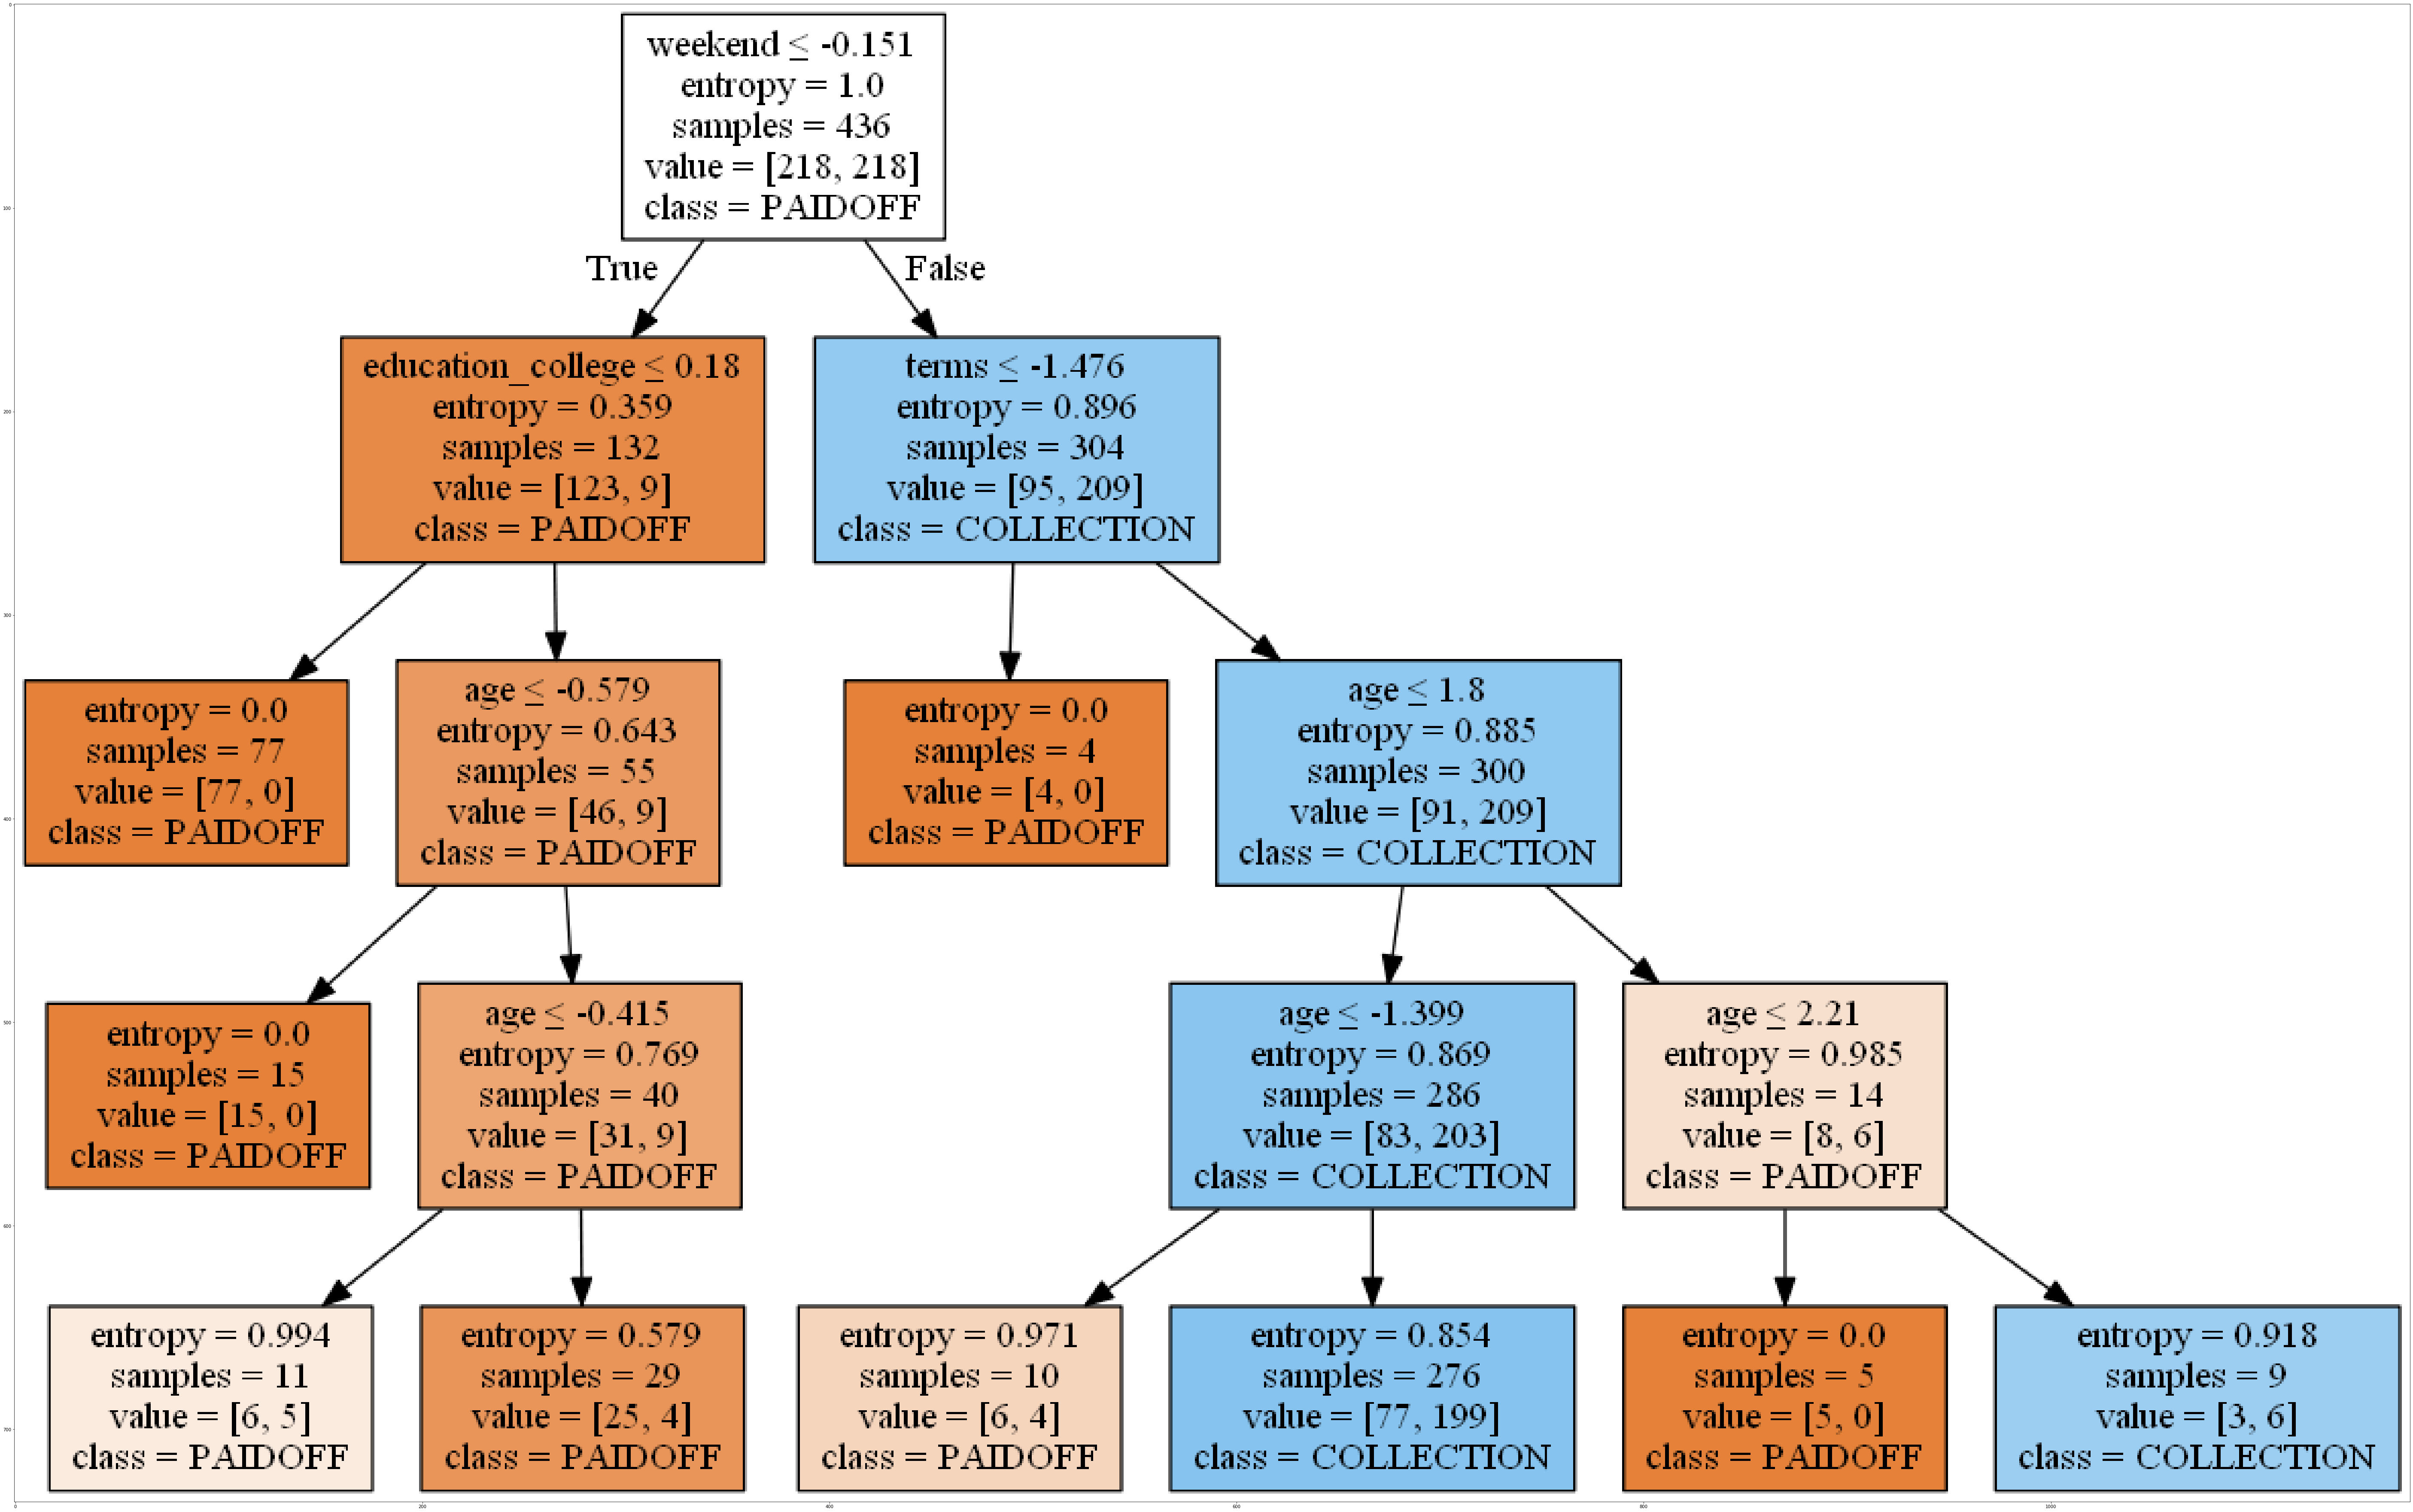

In [92]:
from io import StringIO
import pydotplus
import matplotlib.image as mpimg
from sklearn import tree
featureNames=['Principal','terms','age','Gender','weekend','education_High School or Below','education_Master or Above','education_college']
%matplotlib inline 
dot_data = StringIO()
filename = "drugtree.png"
targetNames = df["loan_status"].unique().tolist()
out=tree.export_graphviz(clfdt,feature_names=featureNames, out_file=dot_data, filled=True,class_names=['PAIDOFF','COLLECTION'],  special_characters=True,rotate=False)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png(filename)
img = mpimg.imread(filename)
plt.figure(figsize=(100, 200))
plt.imshow(img,interpolation='nearest')

### KNN Classifier

In [93]:
#GridSearchCV
param_grid = {'n_neighbors':np.arange(1,20,2),'weights':['uniform','distance']}
knn = KNeighborsClassifier()
knn_cv= GridSearchCV(knn,param_grid,cv=5)
knn_cv.fit(X_train_u,y_train_u)
print(knn_cv.best_score_)
print(knn_cv.best_params_)

0.7889237199582027
{'n_neighbors': 9, 'weights': 'distance'}


In [95]:
clfnbr = KNeighborsClassifier(n_neighbors = 9,weights='distance')
clfnbr.fit(X_train, y_train)
y_pred = clfnbr.predict(X_test)

print("Model 1: KNN Train set Accuracy: ", metrics.accuracy_score(y_train_u, clfnbr.predict(X_train_u)))
print("Model 1: KNN Validation set Accuracy: ", metrics.accuracy_score(y_test, y_pred))
print("Model 1: KNN Jaccard Score:",jaccard_score(y_test, y_pred))
print("Model 1: KNN F1 Score", f1_score(y_test, y_pred))

Model 1: KNN Train set Accuracy:  0.8119266055045872
Model 1: KNN Validation set Accuracy:  0.7692307692307693
Model 1: KNN Jaccard Score: 0.25
Model 1: KNN F1 Score 0.4000000000000001


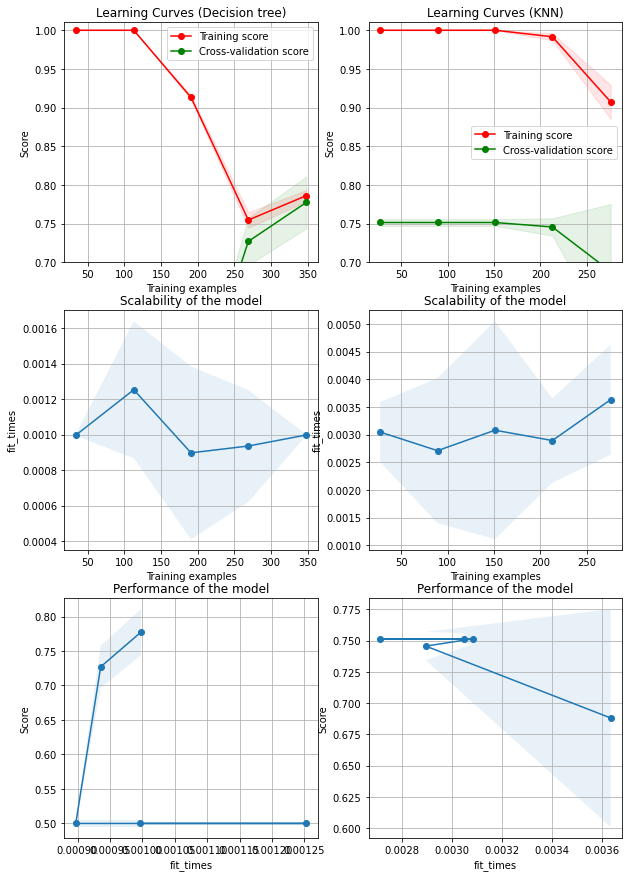

In [96]:
from sklearn.model_selection import learning_curve 
fig, axes = plt.subplots(3, 2, figsize=(10, 15))

title = "Learning Curves (Decision tree)"
plot_learning_curve(clfdt, title, X_train_u, y_train_u, axes=axes[:, 0], ylim=(0.7, 1.01),
                    cv=5, n_jobs=4)

title = r"Learning Curves (KNN)"
plot_learning_curve(clfnbr, title, X, y, axes=axes[:, 1], ylim=(0.7, 1.01),
                    cv=5, n_jobs=4)

plt.show()

## Model Evaluation using Test set

In [97]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [98]:
test_df.drop(['Unnamed: 0','Unnamed: 0.1'],inplace=True,axis=1)
#test_df.head()

In [99]:
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
#df['loan_status']=np.where(df['loan_status']=='COLLECTION',1,0)
#df['Gender']=np.where(df['Gender']=='male',1,0)
test_df.head()
test_df['Gender'].replace(to_replace=['male','female'], value=[1,0],inplace=True)
test_df['loan_status'].replace(to_replace=['PAIDOFF','COLLECTION'], value=[0,1],inplace=True)
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
test_df['Difference_effective_due_date'] = (df['due_date'] - df['effective_date']).dt.days
test_df['Difference_effective_due_date']
#Feature = test_df[['Principal','terms','age','Gender','weekend']]
Feature = pd.get_dummies(test_df[['Principal','terms','age','Gender','weekend','education']],columns=['education'],drop_first=True)




In [100]:
y_true = test_df['loan_status'].values
X_test = sc.transform(Feature)

### Evaluation

In [103]:
KNN_j = jaccard_score(y_true,clfnbr.predict(X_test))
KNN_f1 = f1_score(y_true,clfnbr.predict(X_test))
dtree_j = jaccard_score(y_true,clfdt.predict(X_test))
dtree_f1 = f1_score(y_true,clfdt.predict(X_test))
svm_j = jaccard_score(y_true,clfsvm.predict(X_test))
svm_f1 = f1_score(y_true,clfsvm.predict(X_test))
logreg_j = jaccard_score(y_true,clflr.predict(X_test))
logreg_f1 = f1_score(y_true,clflr.predict(X_test))
logreg_loss = log_loss(y_true, clflr.predict(X_test),eps=1e-15)

In [104]:
col_names =  ['Algorithm','Jaccard', 'F1-score','LogLoss','recommendation']
Report_df = pd.DataFrame(columns = col_names)
Report_df.loc[len(Report_df)] = ['KNN', KNN_j,KNN_f1,'NA','']
Report_df.loc[len(Report_df)] = ['Decision Tree', dtree_j,dtree_f1,'NA','']
Report_df.loc[len(Report_df)] = ['SVM', svm_j,svm_f1,'NA','Best Fit']
Report_df.loc[len(Report_df)] = ['Log_Reg', logreg_j,logreg_f1,logreg_loss,'']
Report_df

,Algorithm,Jaccard,F1-score,LogLoss,recommendation
0,KNN,0.315789,0.480000,NA,
1,Decision Tree,0.428571,0.600000,NA,
2,SVM,0.454545,0.625000,NA,Best Fit
3,Log_Reg,0.366667,0.536585,12.1528,


## Conclusion
#### SVM has the best fit with 77% test accuracy and F1 score of .62